# Performance Benchmarks

This notebook shows the use of the **benchmark** submodule to obtain key performance metrics.

Note that the metrics considered here are not representative of full-data performance. They only provide an indication of performance when restricting the disambiguation to the mention IDs which appear in the benchmark data.

## Data Preparation

To get started, we recover the current disambiguation from `rawinventor.tsv`. The result, a pandas Series indexed by mention id and with values corresponding to cluster assignment, is saved to `disambiguation.tsv`.

In [1]:
import pandas as pd

import wget
import zipfile
import os

import plotly.io as pio
pio.templates.default = "plotly_white" # Set plotly theme

if not os.path.isfile("rawinventor.tsv"):
    wget.download("https://s3.amazonaws.com/data.patentsview.org/download/rawinventor.tsv.zip")
    with zipfile.ZipFile("rawinventor.tsv.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    os.remove("rawinventor.tsv.zip")

if not os.path.isfile("disambiguation.tsv"):
    rawinventor = pd.read_csv("rawinventor.tsv", sep="\t")
    rawinventor["mention-id"] = "US" + rawinventor.patent_id.astype(str) + "-" + rawinventor.sequence.astype(str)
    rawinventor[["mention-id", "inventor_id"]].to_csv("disambiguation.tsv", sep="\t", index=False)
    del(rawinventor)

## Benchmarks

For this example, we consider two disambiguations. One is the current disambiguation, and the other is a trivial disambiguation named "one cluster" where everything is in the same cluster.

The two disambiguation Series are placed in a dictionary.

In [2]:
from pv_evaluation.benchmark import (
    inventor_benchmark_table,
    inventor_benchmark_plot,
)

data = pd.read_csv("disambiguation.tsv", sep="\t")
data.set_index("mention-id", inplace=True)
result = data["inventor_id"]

disambiguations = {
    "current": result,
    "one cluster": 0*result
}

The inventors benchmark table provides the value of key metrics for each combination of benchmark, metric type, and disambiguation.

In [3]:
inventor_benchmark_table(disambiguations)

,benchmark,metric,algorithm,value
0,patentsview-inventors,pairwise precision,current,0.757282
1,patentsview-inventors,pairwise precision,one cluster,0.018074
2,patentsview-inventors,pairwise recall,current,0.987342
3,patentsview-inventors,pairwise recall,one cluster,1.000000
4,patentsview-inventors,cluster precision,current,0.836364
5,patentsview-inventors,cluster precision,one cluster,0.000000
6,patentsview-inventors,cluster recall,current,0.985075
7,patentsview-inventors,cluster recall,one cluster,1.000000
8,israeli-inventors,pairwise precision,current,0.988997
9,israeli-inventors,pairwise precision,one cluster,0.000927


This is plotted below using the `inventor_benchmark_plot` function.

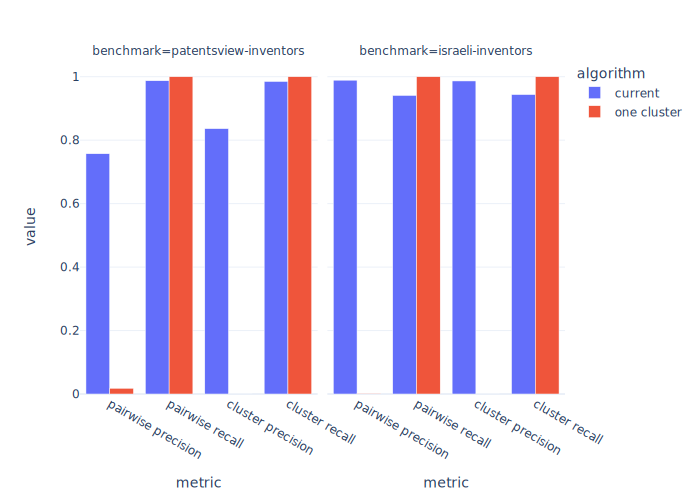

In [4]:
inventor_benchmark_plot(disambiguations).show('svg')

Next, we can look at the tables showcasing two types of errors: predicted clusters which should have been **split**, and predicted cluster which should have been **merged**.

In [5]:
from pv_evaluation.benchmark import inspect_clusters_to_split, inspect_clusters_to_merge, load_israeli_inventors_benchmark, style_cluster_inspection

style_cluster_inspection(inspect_clusters_to_split(result, load_israeli_inventors_benchmark()).head(15))

,prediction,reference
mention-id,,
US4647259-3,fl:ab_ln:amiel-1,472
US4437263-1,fl:ab_ln:amiel-1,470
US5706062-0,fl:ad_ln:stolov-1,16528
US4927240-1,fl:ad_ln:stolov-1,16522
US4580876-1,fl:ad_ln:stolov-1,16522
US4560241-1,fl:ad_ln:stolov-1,16522
US4696347-2,fl:ad_ln:stolov-1,16522
US5617152-0,fl:ad_ln:stolov-1,16522
US4410887-1,fl:ad_ln:stolov-1,16522


In [6]:
rawinventor = pd.read_csv("rawinventor.tsv", sep="\t")
rawinventor["mention-id"] = "US" + rawinventor.patent_id.astype(str) + "-" + rawinventor.sequence.astype(str)
rawinventor.set_index("mention-id", inplace=True)

inspect_clusters_to_merge(result, load_israeli_inventors_benchmark(), join_with=rawinventor[["name_first", "name_last"]])

,reference,prediction,name_first,name_last
mention-id,,,,
US5825476-0,13,h6uzumjdp27ulvxe69um3plwa,Marc,Abitol
US5784282-0,13,fl:ma_ln:abitbol-2,Marc,Abitbol
US5855074-0,13,fl:mo_ln:abitbol-1,Mordechai,Abitbol
US5688262-0,20,fl:ma_ln:abraham-26,Martin David,Abraham
US5783798-0,20,fl:ma_ln:abraham-26,Martin,Abraham
...,...,...,...,...
US5288705-0,18670,fl:jo_ln:zohar-2,Jonathan,Zohar
US5344434-0,19132,fl:el_ln:talmore-1,Eli T.,Talmore
US5344433-0,19132,fl:el_ln:talmore-1,Eli,Talmore
